In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date

from sklearn.preprocessing import MinMaxScaler

import pystan

import matplotlib.pyplot as plt

In [2]:
plt.style.context('seaborn')

In [3]:
df = pd.read_csv('weekly_in_situ_co2_mlo.csv', header=None, parse_dates=[0], dtype={1: np.float16}, names=['date', 'level_ppm'])
df.head()

,date,level_ppm
0,1958-03-29,316.25
1,1958-04-05,317.25
2,1958-04-12,317.75
3,1958-04-19,317.50
4,1958-04-26,316.50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3210 entries, 0 to 3209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3210 non-null   datetime64[ns]
 1   level_ppm  3210 non-null   float16       
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.5 KB


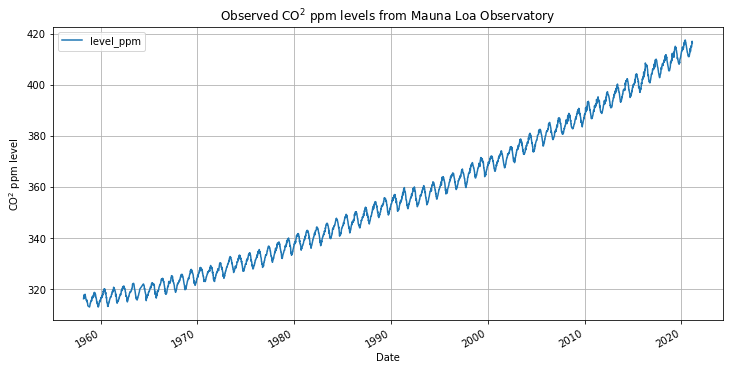

In [5]:
df.plot('date', 'level_ppm', figsize=(12, 6), grid=True)
plt.ylabel('CO$^2$ ppm level')
plt.xlabel('Date')
plt.title('Observed CO$^2$ ppm levels from Mauna Loa Observatory')
plt.savefig('observed_data.png')

In [6]:
last_date = date(2060, 1, 1)
future_dates = pd.date_range(start=max(df['date']),end=last_date).to_series()
scaler = MinMaxScaler()
stan_data = {
    'N': len(df),
    'y': df['level_ppm'],
    'x': scaler.fit_transform(np.array(df['date']).reshape(-1, 1)).reshape(1, -1)[0],
    'nFutureCount': len(future_dates),
    'futureDays': scaler.transform(np.array(future_dates).reshape(-1, 1)).reshape(1, -1)[0]
}
to_predict_dates = df['date'].append(future_dates)
to_predict = scaler.transform(np.array(to_predict_dates).reshape(-1,1)).reshape(1, -1)[0]

In [7]:
bad_stan_model = pystan.StanModel(file='bad_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3eedcd6864f4926a4d799d395ec81fd NOW.


In [8]:
bad_parameters = ['c0', 'c1', 'c2', 'c3', 'sigma']
bad_results = bad_stan_model.sampling(data=stan_data)
print(bad_results.stansummary(pars=bad_parameters))
bad_samples = bad_results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_b3eedcd6864f4926a4d799d395ec81fd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
c0    2018.8  667.74 1202.2 395.08 852.09 2039.9  2867.1 4716.9      3   3.43
c1    105.22    4.93    7.5  97.42 100.18 102.11  107.25 122.79      2   3.08
c2     -1892   513.4 1038.6  -4411  -2562  -1757   -1075 -430.5      4   2.88
c3     -0.33    0.34   0.52  -1.48  -0.68  -0.07 -9.4e-3   0.31      2   3.65
sigma   4.46    0.02   0.06   4.37   4.42   4.46    4.49   4.58     10   1.48

Samples were drawn using NUTS at Thu Apr 22 17:33:02 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [9]:
# Model parameters
bad_c0 = bad_results['c0'][0]
bad_c1 = bad_results['c1'][0]
bad_c2 = bad_results['c2'][0]
bad_c3 = bad_results['c3'][0]

In [10]:
# Stan model future predictions output
bad_prediction = bad_samples['x_future']

# Compute 95% interval of the predicted values
bad_prediction_interval = np.percentile(bad_prediction, axis=0, q=[2.5, 97.5])

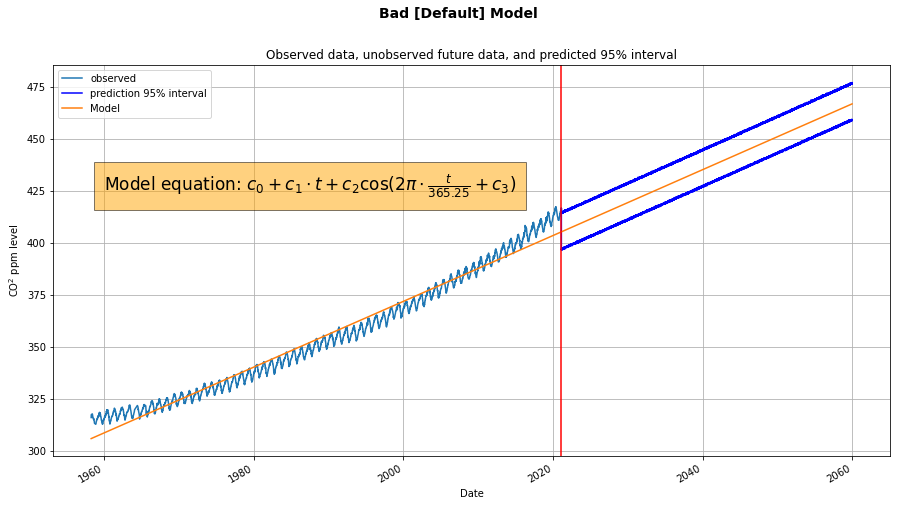

In [12]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Bad [Default] Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions = bad_c0 + bad_c1* to_predict + bad_c2 * np.cos(2 * np.pi * to_predict / 365.25 + bad_c3)
ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()
ax.set_title('Observed data, unobserved future data, and predicted 95% interval')
ax.text(
    date(1960, 1, 1), 425, 
    r'Model equation: $c_0 + c_1 \cdot t + c_2 \cos(2 \pi \cdot \frac{t}{365.25} + c_3$)', 
    fontsize=17, bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10}
)
plt.savefig('bad_model.png')
plt.show()

In [13]:
good_stan_model = pystan.StanModel(file='good_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3771d3bf5aa83d1e13f70e4d446cabbb NOW.


In [14]:
good_parameters = ['c0', 'c1', 'c2', 'c3', 'c4', 'sigma']
good_results = good_stan_model.sampling(data=stan_data)
print(good_results.stansummary(pars=good_parameters))
good_samples = good_results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_3771d3bf5aa83d1e13f70e4d446cabbb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    144.55  154.52 240.03 -289.8 -26.63 191.04 338.25 500.03      2   3.43
c1     63.11     7.8  11.52  51.09  55.24  57.88  67.09  86.52      2   4.54
c2       1.0    0.04   0.06   0.87   0.97   1.02   1.05   1.08      2   3.92
c3    257.83  357.29 522.55 -362.9 -137.2 105.19 569.33 1221.0      2   6.28
c4     -0.52    2.19   3.21  -7.01   -2.1   0.93   1.33   3.89      2   6.03
sigma   2.25  3.1e-3   0.03    2.2   2.23   2.25   2.26    2.3     67   1.04

Samples were drawn using NUTS at Thu Apr 22 17:50:22 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [15]:
# Model parameters
good_c0 = good_results['c0'][0]
good_c1 = good_results['c1'][0]
good_c2 = good_results['c2'][0]
good_c3 = good_results['c3'][0]
good_c4 = good_results['c4'][0]

In [16]:
# Stan model future predictions output
good_prediction = good_samples['x_future']

# Compute 95% interval of the predicted values
good_prediction_interval = np.percentile(good_prediction, axis=0, q=[2.5, 97.5])

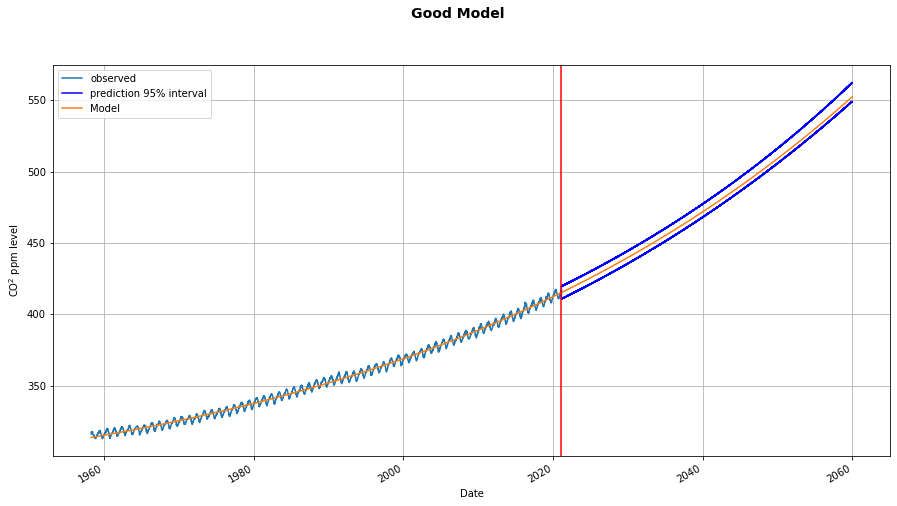

In [17]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Good Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions = good_c0 + good_c1*np.exp(good_c2 * to_predict) + good_c3 * np.cos(2 * np.pi * to_predict / 365.25 + good_c4)
ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()